In [ ]:
import torch
import torch.nn as nn
import timm
from tqdm import tqdm
from vae import *
from datasets import *
import os
from astropy.io import fits
from astropy.wcs import WCS, utils
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
import json
from io import BytesIO
import requests
from copy import deepcopy
from astropy.nddata import Cutout2D
from torch.nn.utils.rnn import pad_sequence
from itertools import chain
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from scipy import stats
from sklearn.ensemble import IsolationForest

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Из лекции

################################################

In [15]:
'''
Function return transforms results to numpy for visualization 

encoder - encoder
decoder - decoder
loader - loader of data
single_pass_handler - return latent and reconstruction transform
return_real - return original images, True/False, default = True
return_recon - return transformed image from decoder, True/False, default = True
return_latent - return latent representation from encoder, True/False, default = True
return_labels - return labels, True/False, default = True
'''
def run_eval(
    encoder,
    decoder,
    loader,
    single_pass_handler,
    return_real=True,
    return_recon=True,
    return_latent=True,
):

    if return_real:
        real = []
    if return_recon:
        reconstr = []
    if return_latent:
        latent = []
    with torch.no_grad():
        for batch_idx, data in enumerate(loader):
            if return_real:
                real.append(data.numpy())
         
            data = data.to(device)
            rep, rec = single_pass_handler(encoder, decoder, data, device='cuda')
            
            if return_latent:
                latent.append(rep.cpu().numpy())
            if return_recon:
                reconstr.append(rec.cpu().numpy())

    result = {}
    if return_real:
        real = np.concatenate(real)
        result["real"] = real.squeeze()
    if return_latent:
        latent = np.concatenate(latent)
        result["latent"] = latent
    if return_recon:
        reconstr = np.concatenate(reconstr)
        result["reconstr"] = reconstr.squeeze()
    return result

In [41]:
def plot_manifold(latent_r, labels=None, alpha=0.9, title=None):
    plt.figure(figsize=(10, 10))
    if labels is None:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], cmap="tab10", alpha=alpha)
        if title:
            plt.title(title)
    else:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], c=labels, cmap="tab10", alpha=alpha)
        plt.colorbar()
        if title:
            plt.title(title)
    plt.show()





def plot_imgs(*args, img_size=28, name=None, single_size=5): #, invert_colors=True
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.ones(((img_size + 1) * len(args) + 1, (img_size + 1) * n + 1))*np.max(args)

    for i in range(n):
        for j in range(len(args)):
            figure[
                j * img_size + (j + 1): (j + 1) * img_size + (j + 1),
                i * img_size + (i + 1) : (i + 1) * img_size + (i + 1),
            ] = args[j][i].squeeze()

    #if invert_colors:
    #    figure = 1 - figure

    plt.figure(figsize=(single_size * n, single_size * len(args)))

    plt.imshow(figure, cmap="gray")

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name, dpi=400, format='pdf', bbox_inches="tight")
    plt.show()

In [6]:
oids, targets = get_only_r_oids('akb.ztf.snad.space.json')

In [7]:
set_random_seed(7)

In [8]:
frames_dataset = AllFramesDataset(oids)
x_train, _ = random_split(frames_dataset, [0.1, 0.9])
train_loader = DataLoader(x_train, batch_size=128, shuffle=True)

## загрузка обученной модели

In [9]:
latent_dim = 36

encoder = VAEEncoder(latent_dim=latent_dim * 2)
decoder = Decoder(latent_dim=latent_dim)

encoder.load_state_dict(torch.load('trained_models/vae/encoder_100ep.zip'))
decoder.load_state_dict(torch.load('trained_models/vae/decoder_100ep.zip'))

<All keys matched successfully>

In [10]:
encoder = encoder.to(device).eval()
decoder = decoder.to(device).eval()

In [11]:
for seq in decoder.decoder.children():
    for child in seq.children():
        if isinstance(child, nn.BatchNorm2d):
            print(child.track_running_stats)

True
True
True
True
True


In [16]:
run_res = run_eval(encoder, decoder, train_loader, vae_pass_handler)

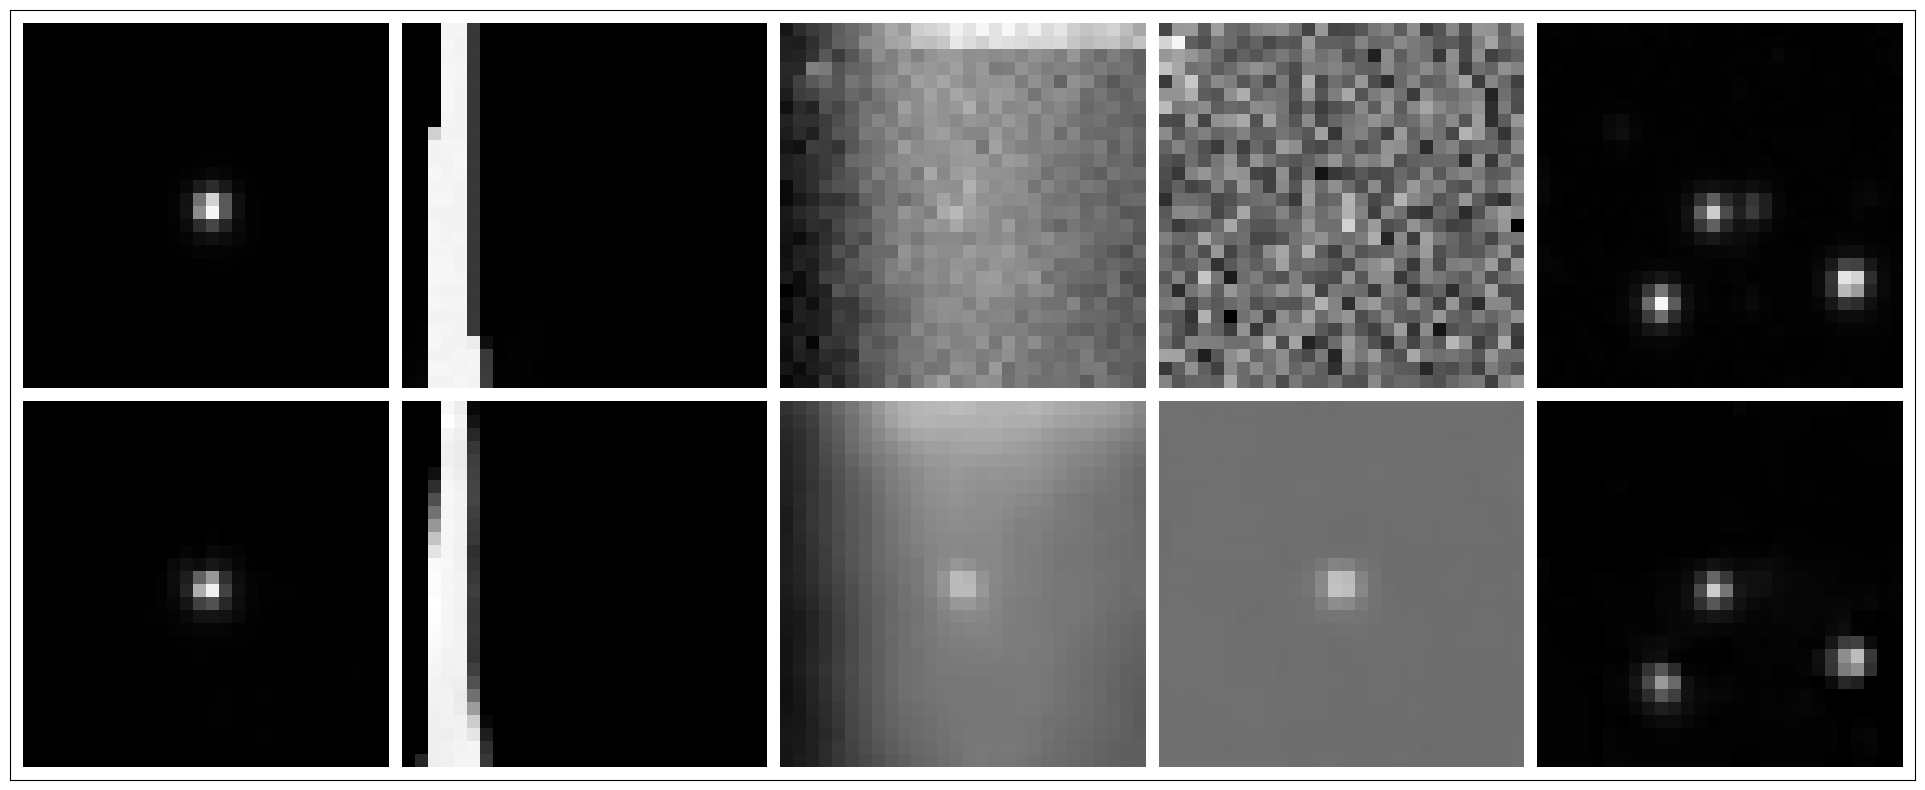

In [42]:
plot_imgs(run_res['real'][1000:1005], run_res['reconstr'][1000:1005], name='visualizations/rand_frames.pdf')

In [19]:
X = run_res['latent'][:, :latent_dim]
isfor = IsolationForest().fit(X)
pred = isfor.predict(X)

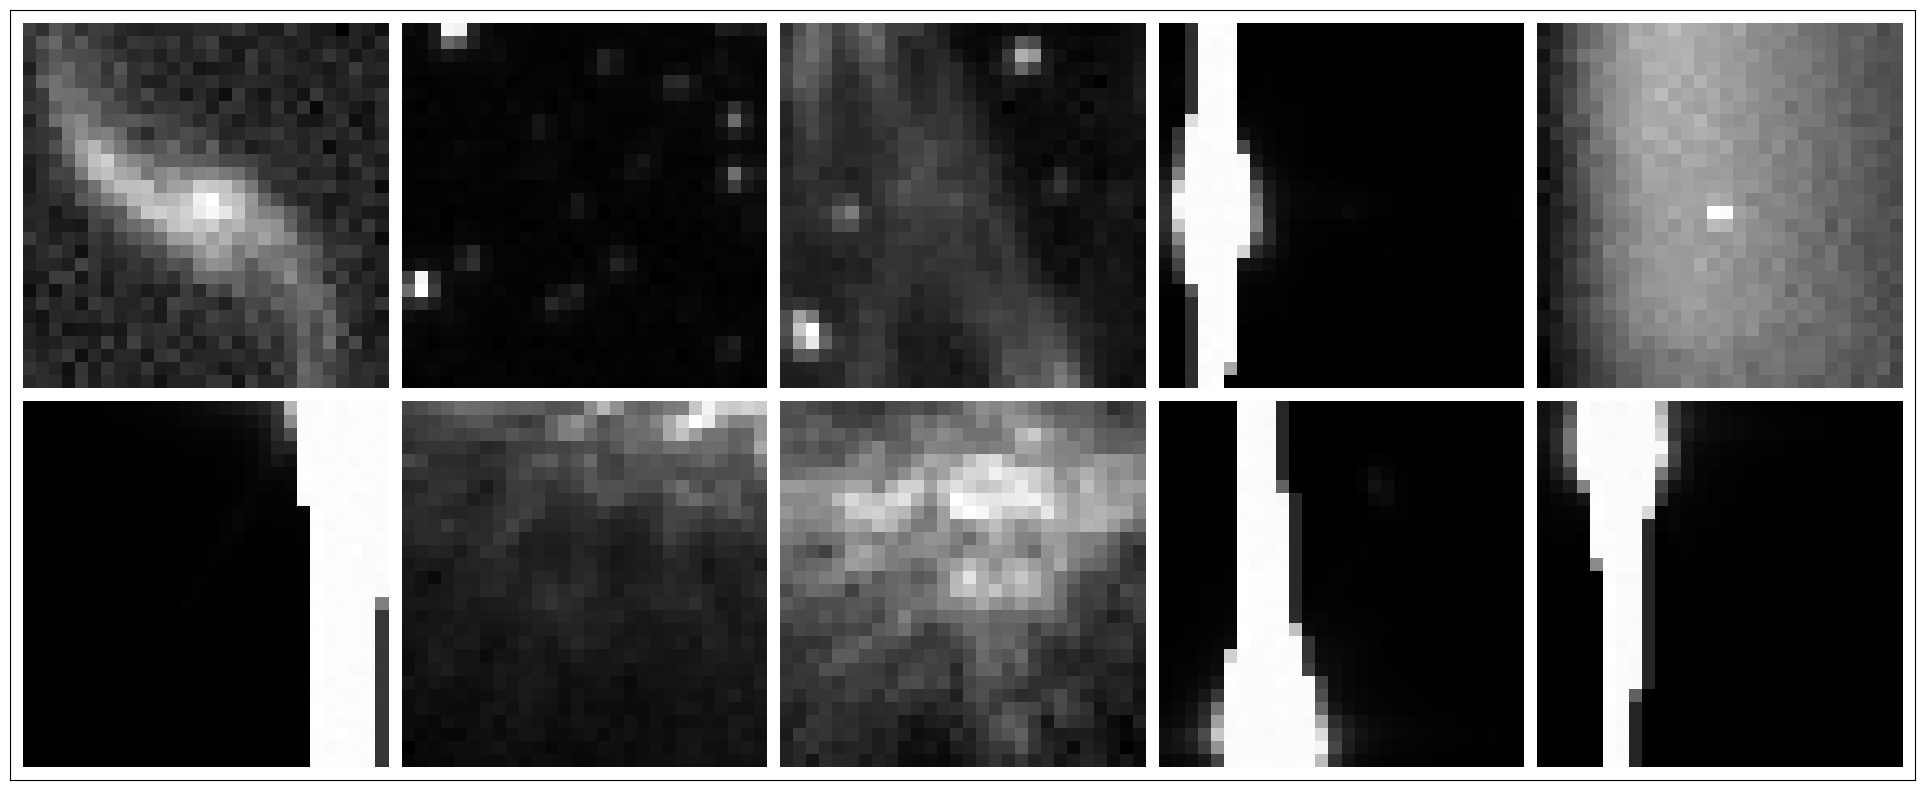

In [43]:
outliers = (pred == -1)
plot_imgs(run_res['real'][outliers][:5], run_res['real'][outliers][5:10], name='visualizations/outliers.pdf')

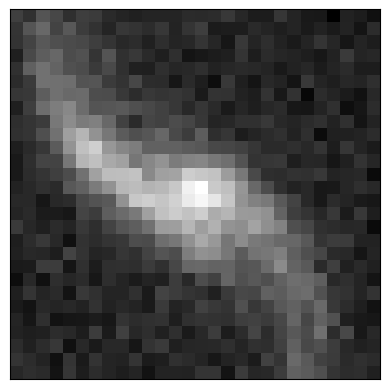

In [40]:
fig, ax = plt.subplots()
ax.imshow(run_res['real'][outliers][0], cmap='gray')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('visualizations/galaxy_frame.pdf', format='pdf', bbox_inches="tight")

In [22]:
sum(pred == -1)/len(x_train)

0.09756890403672255

In [18]:
mu, log_var = vae_split(run_res['latent'])
sigma = np.exp(0.5 * log_var)


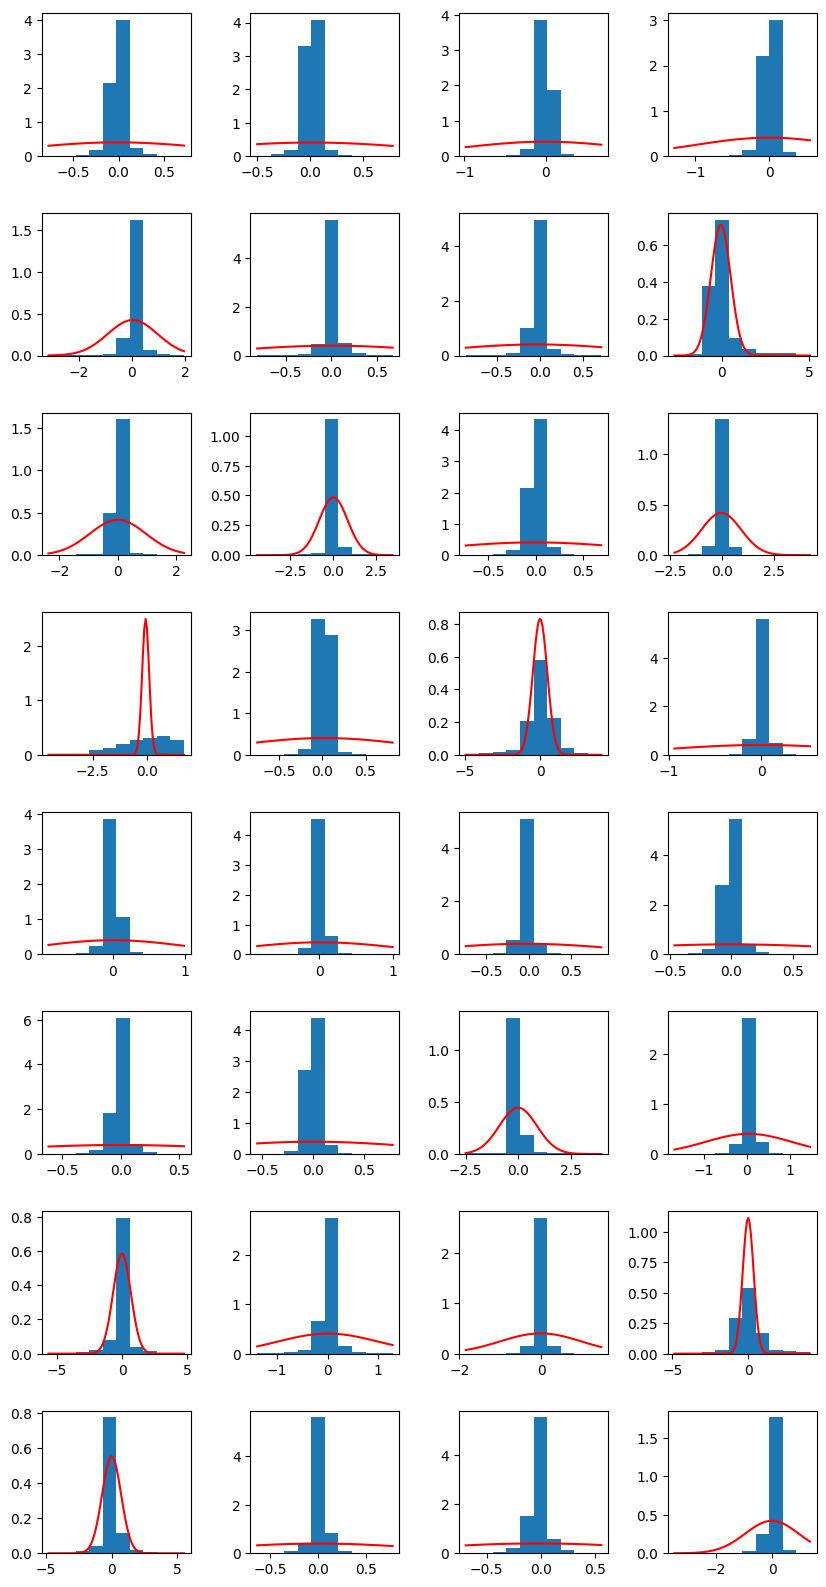

In [40]:
fig, axs = plt.subplots(8, 4, figsize=(10, 20))
for row in range(8):
    for col in range(4):
        axs[row][col].hist(mu[:, row*4+col], density=True)
        x = np.linspace(np.min(mu[:, row*4+col]), np.max(mu[:, row*4+col]), 100)
        pdf = stats.norm.pdf(x, np.mean(mu[:,  row*4+col]), np.mean(sigma[:, row*4+col]))
        axs[row][col].plot(x, pdf, c='red')

plt.subplots_adjust(
                    wspace=0.4,
                    hspace=0.4)

In [42]:
fig.savefig('visualizations/latent_dist', dpi=400, bbox_inches="tight")

## Visualization

In [26]:
latent_dim = 36

learning_rate = 5e-5
encoder = VAEEncoder(latent_dim=latent_dim * 2)
decoder = Decoder(latent_dim=latent_dim)


In [20]:
encoder

VAEEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=1024, out_features=72, bias=True)
  )
)

In [11]:
for batch in train_loader:
    y_enc = encoder(batch.to(device))
    break

mu, log_var = vae_split(y_enc)
sample = vae_reparametrize(mu, log_var) 
y_dec = decoder(sample)


In [28]:
input_name = ["Images"]
output_name = ["Latent state"]

torch.onnx.export(encoder.to('cpu'), batch, "encoder.onnx", input_names=input_name, output_names=output_name)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ValueError: expected 4D input (got 3D input)

In [16]:
input_name = ["Latent state"]
output_name = ["Reconstructed image"]

torch.onnx.export(decoder.to('cpu'), sample.to('cpu'), "decoder.onnx", input_names=input_name, output_names=output_name)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## MNIST

In [8]:
import torchvision.datasets as dset
import torchvision

train_set = dset.MNIST(
    root='mnist', train=True, transform=torchvision.transforms.ToTensor(), download=False
)

torch.manual_seed(42)

x_train, _ = random_split(train_set, [0.2, 0.8])

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    x_train, batch_size=batch_size, shuffle=True
)

In [9]:
def train(
    enc,
    dec,
    loader,
    optimizer,
    single_pass_handler,
    loss_handler,
    epoch,
    log_interval=500,
):

    for batch_idx, (data, lab) in enumerate(loader): 
        batch_size = data.size(0)
        optimizer.zero_grad()
        data = data.to(device)
        lab = lab.to(device)

        latent, output = single_pass_handler(encoder, decoder, data, lab) # reconstructed image drom decoder 

        loss = loss_handler(data, output, latent) # compute loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]".format(
                    epoch,
                    batch_idx * len(data),
                    len(loader.dataset),
                    100.0 * batch_idx / len(loader),
                ).ljust(40), 
                "Loss: {:.6f}".format(loss.item())
            )

            
def run_eval(
    encoder,
    decoder,
    loader,
    single_pass_handler,
    return_real=True,
    return_recon=True,
    return_latent=True,
    return_labels=True,
):

    if return_real:
        real = []
    if return_recon:
        reconstr = []
    if return_latent:
        latent = []
    if return_labels:
        labels = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(loader):
            if return_labels:
                labels.append(label.numpy())
            if return_real:
                real.append(data.numpy())
         
            data = data.to(device)
            label = label.to(device)
            rep, rec = single_pass_handler(encoder, decoder, data, label)
            
            if return_latent:
                latent.append(rep.cpu().numpy())
            if return_recon:
                reconstr.append(rec.cpu().numpy())

    result = {}
    if return_real:
        real = np.concatenate(real)
        result["real"] = real.squeeze()
    if return_latent:
        latent = np.concatenate(latent)
        result["latent"] = latent
    if return_recon:
        reconstr = np.concatenate(reconstr)
        result["reconstr"] = reconstr.squeeze()
    if return_labels:
        labels = np.concatenate(labels)
        result["labels"] = labels
    return result

In [11]:
torch.manual_seed(42)

latent_dim = 24

learning_rate = 5e-4
encoder = VAEEncoder(latent_dim=latent_dim * 2)
decoder = Decoder(latent_dim=latent_dim)

device='cpu'
encoder = encoder.to(device)
decoder = decoder.to(device)

optimizer = torch.optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)
for i in tqdm(range(1, 6)):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=vae_pass_handler,
        loss_handler=vae_loss_handler,
        log_interval=30,
    )

  0%|                                                     | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/12000 (0%)]            Loss: 0.053875
Train Epoch: 1 [1920/12000 (16%)]        Loss: 0.046904
Train Epoch: 1 [3840/12000 (32%)]        Loss: 0.047910
Train Epoch: 1 [5760/12000 (48%)]        Loss: 0.035066
Train Epoch: 1 [7680/12000 (64%)]        Loss: 0.019240
Train Epoch: 1 [9600/12000 (80%)]        Loss: 0.015134
Train Epoch: 1 [11520/12000 (96%)]       Loss: 0.015612


 20%|█████████                                    | 1/5 [00:38<02:34, 38.71s/it]

Train Epoch: 2 [0/12000 (0%)]            Loss: 0.013852
Train Epoch: 2 [1920/12000 (16%)]        Loss: 0.011990
Train Epoch: 2 [3840/12000 (32%)]        Loss: 0.011986
Train Epoch: 2 [5760/12000 (48%)]        Loss: 0.012047
Train Epoch: 2 [7680/12000 (64%)]        Loss: 0.011215
Train Epoch: 2 [9600/12000 (80%)]        Loss: 0.011232
Train Epoch: 2 [11520/12000 (96%)]       Loss: 0.010463


 40%|██████████████████                           | 2/5 [01:19<02:00, 40.00s/it]

Train Epoch: 3 [0/12000 (0%)]            Loss: 0.010273
Train Epoch: 3 [1920/12000 (16%)]        Loss: 0.011011
Train Epoch: 3 [3840/12000 (32%)]        Loss: 0.010472
Train Epoch: 3 [5760/12000 (48%)]        Loss: 0.010421
Train Epoch: 3 [7680/12000 (64%)]        Loss: 0.010178
Train Epoch: 3 [9600/12000 (80%)]        Loss: 0.009139
Train Epoch: 3 [11520/12000 (96%)]       Loss: 0.010391


 60%|███████████████████████████                  | 3/5 [01:59<01:19, 39.88s/it]

Train Epoch: 4 [0/12000 (0%)]            Loss: 0.009793
Train Epoch: 4 [1920/12000 (16%)]        Loss: 0.009506
Train Epoch: 4 [3840/12000 (32%)]        Loss: 0.010415
Train Epoch: 4 [5760/12000 (48%)]        Loss: 0.009180
Train Epoch: 4 [7680/12000 (64%)]        Loss: 0.009352
Train Epoch: 4 [9600/12000 (80%)]        Loss: 0.009725
Train Epoch: 4 [11520/12000 (96%)]       Loss: 0.009374


 80%|████████████████████████████████████         | 4/5 [02:38<00:39, 39.64s/it]

Train Epoch: 5 [0/12000 (0%)]            Loss: 0.009317
Train Epoch: 5 [1920/12000 (16%)]        Loss: 0.009546
Train Epoch: 5 [3840/12000 (32%)]        Loss: 0.010033
Train Epoch: 5 [5760/12000 (48%)]        Loss: 0.009333
Train Epoch: 5 [7680/12000 (64%)]        Loss: 0.009211
Train Epoch: 5 [9600/12000 (80%)]        Loss: 0.009061
Train Epoch: 5 [11520/12000 (96%)]       Loss: 0.008679


100%|█████████████████████████████████████████████| 5/5 [03:15<00:00, 39.09s/it]


In [12]:
encoder = encoder.eval()
decoder = decoder.eval()

In [13]:
run_res = run_eval(encoder, decoder, train_loader, vae_pass_handler)

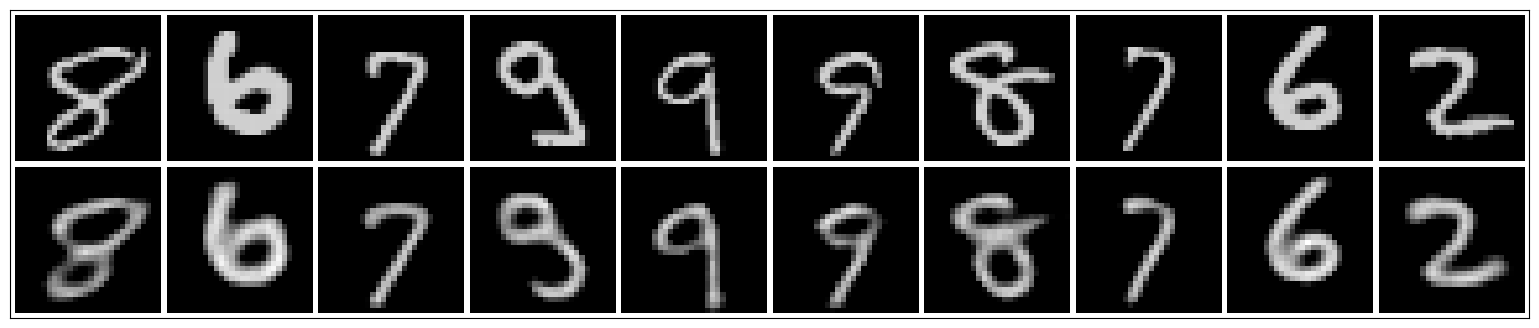

In [14]:
plot_imgs(run_res['real'][100:110], run_res['reconstr'][100:110])

In [15]:
mu, log_var = vae_split(run_res['latent'])
sigma = np.exp(0.5 * log_var)


(array([  29.,  345., 1038., 1607., 2244., 2803., 2431., 1147.,  310.,
          46.]),
 array([-3.79015112, -3.06909847, -2.34804606, -1.62699342, -0.90594083,
        -0.18488824,  0.53616434,  1.25721693,  1.97826946,  2.69932199,
         3.42037463]),
 <BarContainer object of 10 artists>)

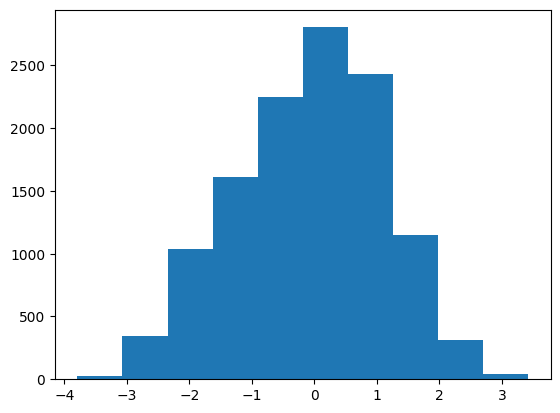

In [16]:
plt.hist(mu[:,1])